# Processing

Creates an adata object from the output of the single-cell proteomics R pipeline.

In [1]:
import pyreadr
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
PATH = "../Code/_targets/objects/dat_SN_maxLFQ_m"

In [3]:
raw = pyreadr.read_r(PATH)

In [4]:
table = raw[None]
table.columns = table.columns.str.lower()

In [5]:
table

,genes,run_chan,value,raw,celltype,label,run,lc_batch,biorep,carrier_amount,gene,norm_prot
0,RPL4,gJD3310_B.A1_1_3580mTRAQ0,9081.961505,gJD3310_B-A1_1_3580,NUC_10,0,3580,7,3,25,RPL4,13.148788
1,EXOSC10,gJD3310_B.A1_1_3580mTRAQ0,3360.138807,gJD3310_B-A1_1_3580,NUC_10,0,3580,7,3,25,EXOSC10,11.714305
2,CHCHD3,gJD3310_B.A1_1_3580mTRAQ0,8874.055077,gJD3310_B-A1_1_3580,NUC_10,0,3580,7,3,25,CHCHD3,13.115378
3,MED17,gJD3310_B.A1_1_3580mTRAQ0,521.822832,gJD3310_B-A1_1_3580,NUC_10,0,3580,7,3,25,MED17,9.027416
4,NCL,gJD3310_B.A1_1_3580mTRAQ0,23323.260931,gJD3310_B-A1_1_3580,NUC_10,0,3580,7,3,25,NCL,14.509482
...,...,...,...,...,...,...,...,...,...,...,...,...
1053437,EIF2AK2,gJD3620_B.M3_1_3843mTRAQ8,3650.834140,gJD3620_B-M3_1_3843,Carrier,8,3843,8,3,25,EIF2AK2,11.834010
1053438,RBM3,gJD3620_B.M3_1_3843mTRAQ8,NaN,gJD3620_B-M3_1_3843,Carrier,8,3843,8,3,25,RBM3,NaN
1053439,STAG2,gJD3620_B.M3_1_3843mTRAQ8,14306.871686,gJD3620_B-M3_1_3843,Carrier,8,3843,8,3,25,STAG2,13.804421
1053440,RBM45,gJD3620_B.M3_1_3843mTRAQ8,NaN,gJD3620_B-M3_1_3843,Carrier,8,3843,8,3,25,RBM45,NaN


Create intensitry matrix.

In [8]:
row_name = "run_chan"
col_name = "genes"
value_name = "value"

rows = table[row_name].unique()
cols = table[col_name].unique()

print(f"Rows: {len(rows)}, Cols: {len(cols)}")

Rows: 806, Cols: 1307


In [9]:
data = np.full((len(rows), len(cols)), np.nan)

df = pd.DataFrame(data, index=rows, columns=cols)

for i, row in table.iterrows():
    df.at[row[row_name], row[col_name]] = row[value_name]

In [10]:
df.head()

,RPL4,EXOSC10,CHCHD3,MED17,NCL,SND1,NUMA1,SIN3A,TPR,BMS1,...,PRPF38A,HELLS,BCKDK,TEX44,EIF3K,EIF2AK2,RBM3,STAG2,RBM45,OSBPL8
gJD3310_B.A1_1_3580mTRAQ0,9081.961505,3360.138807,8874.055077,521.822832,23323.260931,7109.263543,2354.532176,910.943375,2998.929946,1976.363755,...,429.460929,NaN,127.981932,7558.562064,870.453976,NaN,2913.860256,NaN,NaN,NaN
gJD3311_B.A2_1_3581mTRAQ0,2141.752484,751.406230,3070.759020,497.566116,8130.345371,3118.175510,1505.925920,993.007338,2444.286494,1199.259740,...,419.459274,NaN,NaN,1593.616064,540.344244,NaN,23171.395283,978.359736,NaN,NaN
gJD3312_B.A3_1_3582mTRAQ0,1622.976801,1310.453583,2061.649403,3007.393115,9563.479796,2590.382573,1856.167331,789.576499,2705.681052,864.215725,...,NaN,NaN,NaN,2472.685355,899.172115,55.802312,687.475347,782.406113,NaN,1195.412120
gJD3313_B.A4_1_3583mTRAQ0,4263.647995,2957.419135,4597.316990,NaN,16374.792687,3996.944496,1209.966941,1495.453422,2325.775274,769.202022,...,243.281295,NaN,236.438031,4022.725033,744.033310,NaN,411.041063,NaN,NaN,NaN
gJD3314_B.A5_1_3584mTRAQ0,2502.896619,1081.615081,3243.491013,172.348852,10618.356651,3667.827863,1924.791326,2140.902104,3148.268126,2798.229369,...,1096.038723,NaN,NaN,2277.256667,977.890643,NaN,809.683688,700.337633,142.879921,1299.979572


Create obs table.

In [11]:
table = table.set_index(row_name)

obs_table = table[~table.index.duplicated(keep='first')]
obs_table = obs_table[["celltype", "label", "run", "lc_batch", "biorep", "carrier_amount"]]

obs_table["celltype"] = obs_table["celltype"].astype("category")
obs_table["label"] = obs_table["label"].astype("category")
obs_table["run"] = obs_table["run"].astype("category")
obs_table["lc_batch"] = obs_table["lc_batch"].astype("category")
obs_table["biorep"] = obs_table["biorep"].astype("category")

In [12]:
obs_table.head()

,celltype,label,run,lc_batch,biorep,carrier_amount
run_chan,,,,,,
gJD3310_B.A1_1_3580mTRAQ0,NUC_10,0,3580,7,3,25
gJD3311_B.A2_1_3581mTRAQ0,NUC_NT,0,3581,7,3,25
gJD3312_B.A3_1_3582mTRAQ0,NUC_60,0,3582,7,3,25
gJD3313_B.A4_1_3583mTRAQ0,NUC_30,0,3583,7,3,25
gJD3314_B.A5_1_3584mTRAQ0,NUC_10,0,3584,7,3,25


Create var table.

In [13]:
table = table.set_index(col_name)

var_table = table[~table.index.duplicated(keep='first')]
var_table = var_table[["gene"]]

var_table.columns = [col.lower() for col in var_table.columns]

var_table["gene"] = var_table["gene"].astype("category")

In [14]:
var_table.head()

,gene
genes,
RPL4,RPL4
EXOSC10,EXOSC10
CHCHD3,CHCHD3
MED17,MED17
NCL,NCL


Create anndata object.

In [15]:
adata = sc.AnnData(X=df, obs=obs_table, var=var_table)

sc.pp.log1p(adata, base=2)
adata.layers["raw"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

/home/rasmus/anaconda3/envs/leduc2024/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:384: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [16]:
adata

AnnData object with n_obs × n_vars = 806 × 1307
    obs: 'celltype', 'label', 'run', 'lc_batch', 'biorep', 'carrier_amount'
    var: 'gene'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [17]:
adata.write("derks2024.h5ad")

In [18]:
adata

AnnData object with n_obs × n_vars = 806 × 1307
    obs: 'celltype', 'label', 'run', 'lc_batch', 'biorep', 'carrier_amount'
    var: 'gene'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [22]:
adata

AnnData object with n_obs × n_vars = 806 × 1307
    obs: 'celltype', 'label', 'run', 'lc_batch', 'biorep', 'carrier_amount'
    var: 'gene'
    uns: 'log1p', 'pca', 'lc_batch_colors', 'celltype_colors', 'label_colors', 'biorep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

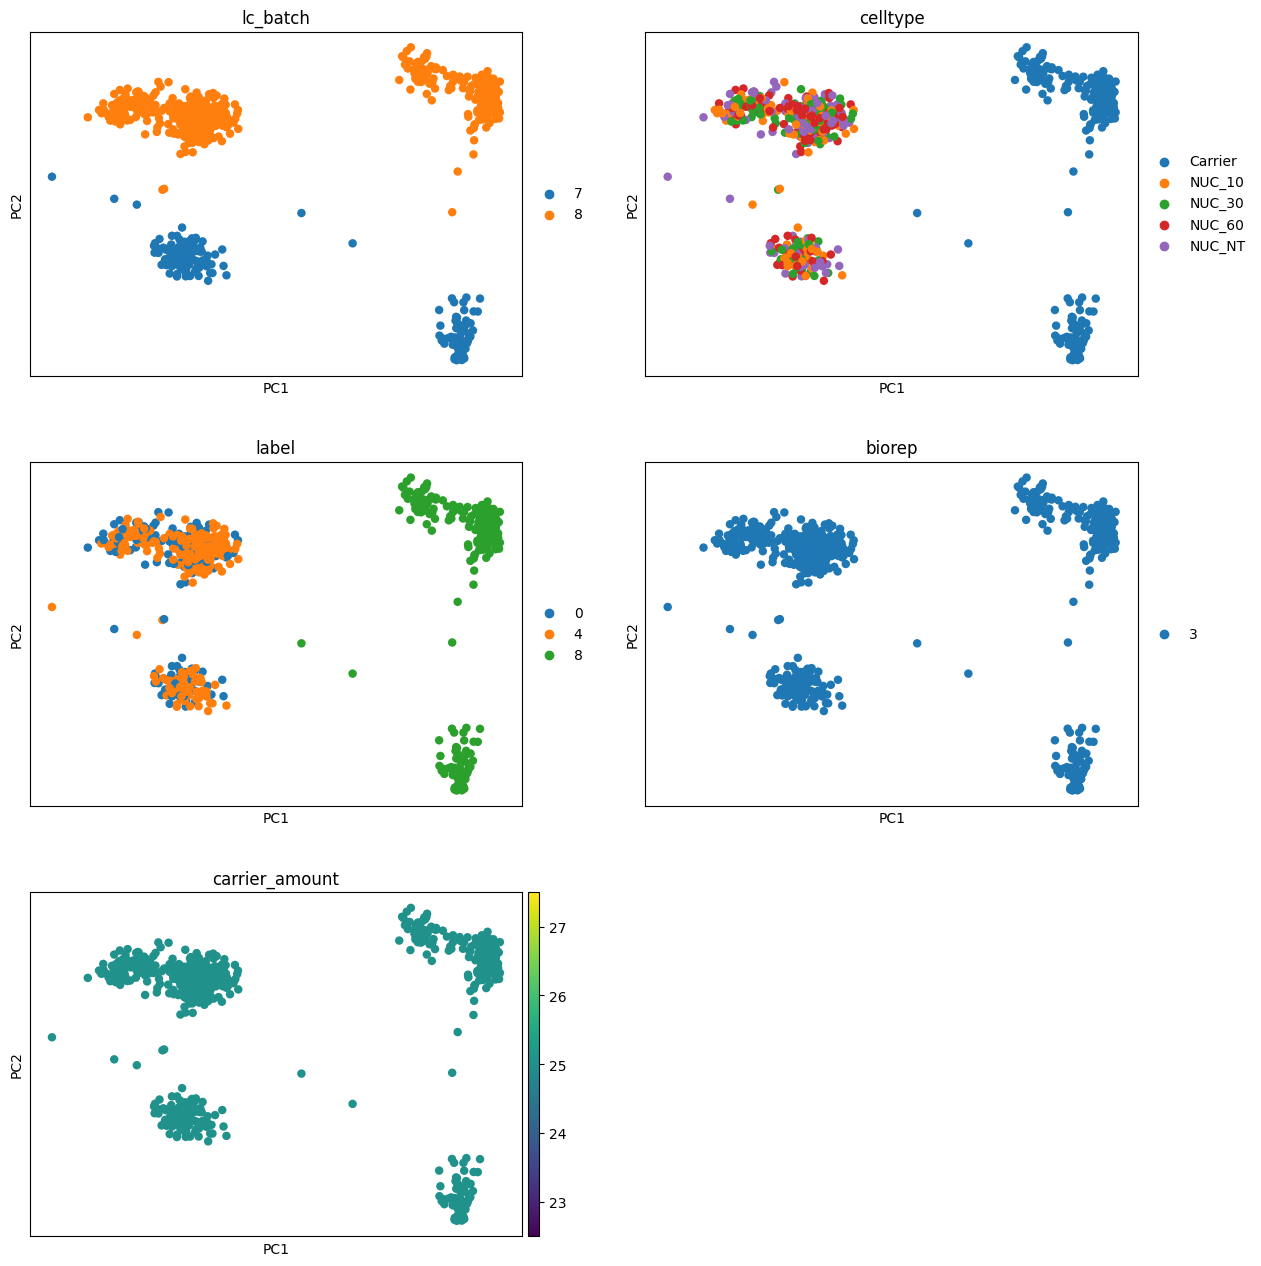

In [19]:
sc.pl.pca(adata, color=["lc_batch", "celltype", "label", "biorep", "carrier_amount"], ncols=2)

In [3]:
adata = sc.read("derks2024.h5ad")